In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pltpi
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_curve,auc
import matplotlib.pyplot as plt

# DATASET CREATION

Predicting delay in general is very difficult task without real time info. After trying multiple models we concluded that delay prediction may not be possible. However, public data is available for arrivals into each airport. We already had data for departures from the previous milestone. So combining these two datasets could help classify propogating delays which are classified as Late Aircraft Delays. Below both datasets are merged carefully to anaylze this info.

In [2]:
df=pd.read_csv("AllData_Merged_departurefinal_removedoutliers1000.csv")
#df=pd.read_csv("AllData_Mergedall.csv")
df_arriv=pd.read_csv("AllData_Merged_arrivalsfinal.csv")
df.head()
df.columns=df.columns.str.upper()
df_arriv.columns=df_arriv.columns.str.upper()
df_arriv.dtypes

CARRIER CODE                                 object
DATE (MM/DD/YYYY)                            object
FLIGHT NUMBER                               float64
TAIL NUMBER                                  object
ORIGIN AIRPORT                               object
SCHEDULED ARRIVAL TIME                       object
ACTUAL ARRIVAL TIME                          object
SCHEDULED ELAPSED TIME (MINUTES)            float64
ACTUAL ELAPSED TIME (MINUTES)               float64
ARRIVAL DELAY (MINUTES)                     float64
WHEELS-ON TIME                               object
TAXI-IN TIME (MINUTES)                      float64
DELAY CARRIER (MINUTES)                     float64
DELAY WEATHER (MINUTES)                     float64
DELAY NATIONAL AVIATION SYSTEM (MINUTES)    float64
DELAY SECURITY (MINUTES)                    float64
DELAY LATE AIRCRAFT ARRIVAL (MINUTES)       float64
ARRIVAL_AIRPORT                              object
dtype: object

In [3]:
# Merge arrival and delay datasets with needed info
# Convert date
df_arriv['DATE (MM/DD/YYYY)'] = pd.to_datetime(df_arriv['DATE (MM/DD/YYYY)'])
df['DATE (MM/DD/YYYY)'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'])

#label row with origin dataset
df_arriv['TYPE'] = 'ARRIVAL'
df['TYPE'] = 'DEPARTURE'

# Rename columns so both fit into the same structure
df_arriv_renamed = df_arriv.rename(columns={
    "SCHEDULED ARRIVAL TIME": "SCHEDULED TIME",
    "ACTUAL ARRIVAL TIME": "ACTUAL TIME",
    "ARRIVAL_AIRPORT": "AIRPORT",
    "ARRIVAL DELAY (MINUTES)": "ARR_DELAY_MIN",
    "FLIGHT NUMBER": "FLIGHT_NUMBER",
    "CARRIER CODE": "CARRIER_CODE",
    "SCHEDULED ELAPSED TIME (MINUTES)": "SCHEDULED_ELAPSED_MIN"  # Add here
})

df_dep_renamed = df.rename(columns={
    "SCHEDULED DEPARTURE TIME": "SCHEDULED TIME",
    "ACTUAL DEPARTURE TIME": "ACTUAL TIME",
    "DEPARTURE_AIRPORT": "AIRPORT",
    "DESTINATION AIRPORT": "DEST_AIRPORT",
    "DELAY LATE AIRCRAFT ARRIVAL (MINUTES)": "LATE_ARRIVAL_DELAY_MIN",
    "DEPARTURE DELAY (MINUTES)": "DEP_DELAY_MIN",
    "FLIGHT NUMBER": "FLIGHT_NUMBER",
    "CARRIER CODE": "CARRIER_CODE"
})

# Add missing columns with NaN where they don't exist
df_arriv_renamed["DEST_AIRPORT"] = pd.NA
df_arriv_renamed["LATE_ARRIVAL_DELAY_MIN"] = pd.NA
df_arriv_renamed["DEP_DELAY_MIN"] = pd.NA

df_dep_renamed["ARR_DELAY_MIN"] = pd.NA
df_dep_renamed["SCHEDULED_ELAPSED_MIN"] = pd.NA  # Add column as NaN for departures

# Select columns
aligned_cols = [
    "DATE (MM/DD/YYYY)",
    "TAIL NUMBER",
    "CARRIER_CODE",
    "FLIGHT_NUMBER",
    "TYPE",
    "SCHEDULED TIME",
    "ACTUAL TIME",
    "AIRPORT",
    "DEST_AIRPORT",
    "ARR_DELAY_MIN",
    "LATE_ARRIVAL_DELAY_MIN",
    "DEP_DELAY_MIN",
    "SCHEDULED_ELAPSED_MIN"  # Include in final aligned columns
]

df_arriv_final = df_arriv_renamed[aligned_cols]
df_dep_final = df_dep_renamed[aligned_cols]

# Combine 
df_comb = pd.concat([df_arriv_final, df_dep_final], ignore_index=True)

# Sort by DATE → TAIL NUMBER (to identify propogating flights)
df_comb = df_comb.sort_values(["DATE (MM/DD/YYYY)", "TAIL NUMBER", "TYPE", "SCHEDULED TIME"])

# Show results
df_comb.shape

/var/folders/0d/zhgjdsn95lz0mh6rfzh7mk_m0000gp/T/ipykernel_74694/2845052342.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_comb = pd.concat([df_arriv_final, df_dep_final], ignore_index=True)


(283643, 13)

Once datasets are combined we want to create flight pairs to predict propogating delays. We first find all flights under the same flight number for a given date. We then merge an arrival that occured directly before departure for the same flight at the same airport. Thus if a flight arrived late we can conclude that the departure on the same day could be affected by a Late Aircraft Delay.

In [4]:
# Prepare an empty list to collect the pairs
paired_rows = []

# Ensure actual time is datetime
df_comb["ACTUAL TIME"] = pd.to_datetime(df_comb["ACTUAL TIME"], format="%H:%M", errors="coerce")

# Group by DATE and TAIL NUMBER
grouped = df_comb.groupby(["DATE (MM/DD/YYYY)", "TAIL NUMBER"])

for (date, tail), group in grouped:
    # Sort by actual time
    g = group.sort_values("ACTUAL TIME").reset_index(drop=True)
    
    i = 0
    while i < len(g) - 1:
        current = g.loc[i]
        next_row = g.loc[i + 1]
        
        # Only pair if first is ARRIVAL and next is DEPARTURE
        if current["TYPE"] == "ARRIVAL" and next_row["TYPE"] == "DEPARTURE":
            paired_rows.append({
                # Arrival info
                "DATE": date,
                "TAIL_NUMBER": tail,
                "ARR_CARRIER": current["CARRIER_CODE"],
                "ARR_FLIGHT_NUMBER": current["FLIGHT_NUMBER"],
                "ARR_SCHEDULED": current["SCHEDULED TIME"],
                "ARR_ACTUAL": current["ACTUAL TIME"],
                "ARR_AIRPORT": current["AIRPORT"],
                "ARR_DELAY_MIN": current["ARR_DELAY_MIN"],
                "ARR_SCHEDULED_ELAPSED_MIN": current["SCHEDULED_ELAPSED_MIN"],  # <-- added here
                # Departure info
                "DEP_CARRIER": next_row["CARRIER_CODE"],
                "DEP_FLIGHT_NUMBER": next_row["FLIGHT_NUMBER"],
                "DEP_SCHEDULED": next_row["SCHEDULED TIME"],
                "DEP_ACTUAL": next_row["ACTUAL TIME"],
                "DEP_AIRPORT": next_row["AIRPORT"],
                "DEST_AIRPORT": next_row["DEST_AIRPORT"],
                "DEP_DELAY_MIN": next_row["DEP_DELAY_MIN"],
                "LATE_ARRIVAL_DELAY_MIN": next_row["LATE_ARRIVAL_DELAY_MIN"]
            })
            i += 2
        else:
            i += 1

# Create the paired DataFrame
df_paired = pd.DataFrame(paired_rows)

# Show results
print(df_paired.head())

        DATE TAIL_NUMBER ARR_CARRIER  ARR_FLIGHT_NUMBER ARR_SCHEDULED  \
0 2024-01-05      N101DQ          DL              840.0         17:05   
1 2024-01-05      N106DN          DL             1454.0         14:04   
2 2024-01-05      N106SY          OO             5279.0         16:22   
3 2024-01-05      N107DN          DL             2834.0         17:33   
4 2024-01-05      N107SY          OO             4628.0         11:58   

           ARR_ACTUAL ARR_AIRPORT  ARR_DELAY_MIN  ARR_SCHEDULED_ELAPSED_MIN  \
0 1900-01-01 16:52:00         DEN          -13.0                      207.0   
1 1900-01-01 13:39:00         DEN          -25.0                      139.0   
2 1900-01-01 15:58:00         DEN          -24.0                      162.0   
3 1900-01-01 17:25:00         DEN           -8.0                      201.0   
4 1900-01-01 12:51:00         ORD           53.0                      124.0   

  DEP_CARRIER  DEP_FLIGHT_NUMBER DEP_SCHEDULED          DEP_ACTUAL  \
0          DL   

# DATA CLEANING

Basic cleaning tasks were done to prepare the final tasks. To summarize the following were done.
1. Turnaround columns were created. scheduled_turnaround measures time between scheduled arrival and schedulded departure for each paried flight. scheduled_turnaround_adjusted adds arrival delay info by subtracting arrival delay from scheduled_turnaround.
2. Duplicate columns were cleaned or merged.
3. Data with arrival delay below 0 was dropped. None of these flights have late aircraft delay so they are pointless to analyze.
4. Overnight flights were also dropped. It is hard to find pairs due to not having data from the day before. Our data was taken for noncontiguous day samples.

In [5]:

#Create turnaround columns

df_paired["ARR_SCHEDULED"] = pd.to_datetime(df_paired["ARR_SCHEDULED"], format="%H:%M", errors="coerce")
df_paired["DEP_SCHEDULED"] = pd.to_datetime(df_paired["DEP_SCHEDULED"], format="%H:%M", errors="coerce")

#create turnaround columns
df_paired["scheduled_turnaround"] = (df_paired["DEP_SCHEDULED"] - df_paired["ARR_SCHEDULED"]).dt.total_seconds() / 60


df_paired["scheduled_turnaround_adjusted"] = df_paired["scheduled_turnaround"].apply(
    lambda x: x + 24*60 if x < 0 else pd.NA
)


df_paired["actual_turnaround"] = df_paired["scheduled_turnaround"] - df_paired["ARR_DELAY_MIN"]

In [6]:
#drop and merge columns to clean
df_paired["ARR_SCHEDULED"] = df_paired["ARR_SCHEDULED"].dt.strftime("%H:%M")
df_paired["DEP_SCHEDULED"] = df_paired["DEP_SCHEDULED"].dt.strftime("%H:%M")
df_paired["ARR_ACTUAL"] = df_paired["ARR_ACTUAL"].dt.strftime("%H:%M")
df_paired["DEP_ACTUAL"] = df_paired["DEP_ACTUAL"].dt.strftime("%H:%M")

df_paired["CARRIER"] = df_paired["DEP_CARRIER"]


df_paired["AIRPORT"] = df_paired["DEP_AIRPORT"]

df_paired = df_paired.drop(columns=["ARR_CARRIER", "DEP_CARRIER", "ARR_AIRPORT", "DEP_AIRPORT"])


print(df_paired.head())

        DATE TAIL_NUMBER  ARR_FLIGHT_NUMBER ARR_SCHEDULED ARR_ACTUAL  \
0 2024-01-05      N101DQ              840.0         17:05      16:52   
1 2024-01-05      N106DN             1454.0         14:04      13:39   
2 2024-01-05      N106SY             5279.0         16:22      15:58   
3 2024-01-05      N107DN             2834.0         17:33      17:25   
4 2024-01-05      N107SY             4628.0         11:58      12:51   

   ARR_DELAY_MIN  ARR_SCHEDULED_ELAPSED_MIN  DEP_FLIGHT_NUMBER DEP_SCHEDULED  \
0          -13.0                      207.0              840.0         18:15   
1          -25.0                      139.0             1602.0         15:15   
2          -24.0                      162.0             5321.0         17:45   
3           -8.0                      201.0             2663.0         18:43   
4           53.0                      124.0             4739.0         13:05   

  DEP_ACTUAL DEST_AIRPORT  DEP_DELAY_MIN  LATE_ARRIVAL_DELAY_MIN  \
0      18:07      

In [7]:
#create overnight column to drop these flights
df_paired["overnight"] = ((df_paired["scheduled_turnaround"] < 0) & 
                          (df_paired["scheduled_turnaround_adjusted"] < 20*60)).astype(int)



In [8]:
#drop flights with arrival delay less then 0 not canidates
df_final = df_paired[df_paired["ARR_DELAY_MIN"] > 0].copy()
df_final.shape
percent = (len(df_final) / len(df_paired)) * 100
percent

32.19233592997645

In [123]:

df_final = df_final[~((df_final["overnight"] == 0) & (df_final["scheduled_turnaround"] < 0))].copy()
df_final.shape

(32984, 19)

In [9]:
#drop overnight flights
df_final = df_final[df_final["overnight"] == 0].copy()

In [10]:
# Drop overnight flag and adjusted columns
df_final = df_final.drop(columns=["overnight", "scheduled_turnaround_adjusted"])

# Create new adjusted turnaround column
df_final["scheduled_turnaround_adjusted"] = df_final["scheduled_turnaround"] - df_final["ARR_DELAY_MIN"]





In [11]:
#remove more overnight flights where flight arrived the following day

df_final["ARR_ACTUAL"] = pd.to_datetime(df_final["ARR_ACTUAL"], format="%H:%M", errors="coerce")
df_final["ARR_SCHEDULED"] = pd.to_datetime(df_final["ARR_SCHEDULED"], format="%H:%M", errors="coerce")


df_final["arrival_diff"] = (df_final["ARR_ACTUAL"] - df_final["ARR_SCHEDULED"]).dt.total_seconds() / 60


num_discrepancies = df_final[(df_final["arrival_diff"] < 0) & (df_final["ARR_DELAY_MIN"] > 0)].shape[0]
print("Number of flights where ARR_ACTUAL < ARR_SCHEDULED but ARR_DELAY_MIN > 0:", num_discrepancies)
df_final = df_final[~((df_final["arrival_diff"] < 0) & (df_final["ARR_DELAY_MIN"] > 0))].copy()

print(df_final.shape)

Number of flights where ARR_ACTUAL < ARR_SCHEDULED but ARR_DELAY_MIN > 0: 102
(33297, 19)


# MODELS


Our goal is to predict Late Aircraft Delay. We first start with a binary classification task to classify if late aircraft delay occurs. We use features such as Carrier,Airport,Arrival time,Month and duration of flight. We also use scheduled_turnaround as the difference between scheduled arrival and departure. As seen above we only analyze flights with arrival delay > 0 since no other flights have Late Aircraft Delay.

We have the choice to use full arrival delay info which would give the exact length of the delay. This is a very strong feature with the caveat that we must wait to determine the delay length of the flight. As seen in the decision trees at the end of the notebook this singular feature included in scheduled_turnaround_adjusted on random forest e gives 83 percent accuracy by itself. Thus we propose to not use full arrival delay info for classification. This gives a weaker model about 69 percent accuracy however the features are more balanced using multiple features helps the decision tree. Furthermore, we do not have to wait to determine the delay length of the flight.

Additionally, we also look to predict the length of the late aircraft delay. Here we use full arrival delay info as it is neccesarry to produce reasonable results. We use regression however due to poor performance of linear regression we use a RandomForestRegressor which gives decent results.

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

# Copy df_final and add features

df_model = df_final.copy()
df_model["MONTH"] = df_model["ARR_SCHEDULED"].dt.month
df_model["ARRIVAL_HOUR"] = df_model["ARR_ACTUAL"].dt.hour
df_model["LATE_ARRIVAL_FLAG"] = (df_model["LATE_ARRIVAL_DELAY_MIN"] > 0).astype(int)

# Features including ARR_SCHEDULED_ELAPSED_MIN
features = ["CARRIER","AIRPORT", "scheduled_turnaround", "ARR_SCHEDULED_ELAPSED_MIN", "ARRIVAL_HOUR", "MONTH"]
target = "LATE_ARRIVAL_FLAG"

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df_model[features], df_model[target], test_size=0.2, random_state=42, stratify=df_model[target]
)

categorical_features = ["CARRIER", "AIRPORT","ARRIVAL_HOUR", "MONTH"]
numerical_features = ["scheduled_turnaround", "ARR_SCHEDULED_ELAPSED_MIN"]

# Column transformer with scaling for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features)
    ]
)
#Models
pipelines = {
    "Logistic Regression": ImbPipeline(steps=[
        ("preprocess", preprocessor),
        ("resample", RandomUnderSampler(random_state=42)),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42))
    ]),

    "Decision Tree": ImbPipeline(steps=[
        ("preprocess", preprocessor),
        ("resample", RandomUnderSampler(random_state=42)),
        ("clf", DecisionTreeClassifier(class_weight="balanced", max_depth=20, random_state=42))
    ]),

    "Random Forest": ImbPipeline(steps=[
        ("preprocess", preprocessor),
        ("resample", RandomUnderSampler(random_state=42)),
        ("clf", RandomForestClassifier(class_weight="balanced", n_estimators=300, min_samples_leaf=5, max_depth=20, random_state=42))
    ]),

    "KNN": ImbPipeline(steps=[
        ("preprocess", preprocessor),
        ("resample", RandomUnderSampler(random_state=42)),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ])
}



In [134]:
#Results
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


results = []

for name, model in pipelines.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model["clf"], "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    results.append([name, acc, prec, rec, f1, roc])

df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"])
df_results = df_results.round(4)
print(df_results)
df_results.to_csv("classifcationresults.csv", index=False)

                 Model  Accuracy  Precision  Recall  F1-score  ROC-AUC
0  Logistic Regression    0.6628     0.4721  0.6963    0.5627   0.7257
1        Decision Tree    0.6455     0.4534  0.6721    0.5415   0.6628
2        Random Forest    0.6925     0.5045  0.7249    0.5949   0.7712
3                  KNN    0.6708     0.4797  0.6716    0.5597   0.7282


## REGRESSION TO PREDICT DELAY TIME (USE FULL ARRIVAL DELAY INFO)

Linear Regression metrics:
MAE: 19.126612829077658
RMSE: 30.5348895776015
R²: 0.20024501404493056


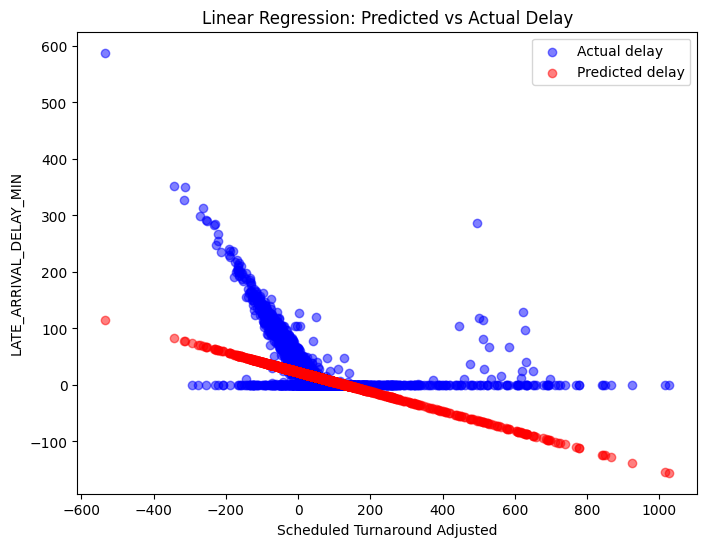

In [100]:
#Linear Regression
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
X = df_final[['scheduled_turnaround_adjusted']]
y = df_final['LATE_ARRIVAL_DELAY_MIN']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on test
y_pred = lr.predict(X_test)


# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Linear Regression metrics:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)


# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Actual delay')
plt.scatter(X_test, y_pred, color='red', alpha=0.5, label='Predicted delay')
plt.xlabel('Scheduled Turnaround Adjusted')
plt.ylabel('LATE_ARRIVAL_DELAY_MIN')
plt.title('Linear Regression: Predicted vs Actual Delay')
plt.legend()
plt.show()

Linear Regression (log-transformed target) metrics:
MAE: 14.730160009399738
RMSE: 34.083079540331546
R²: 0.0035812187333836842


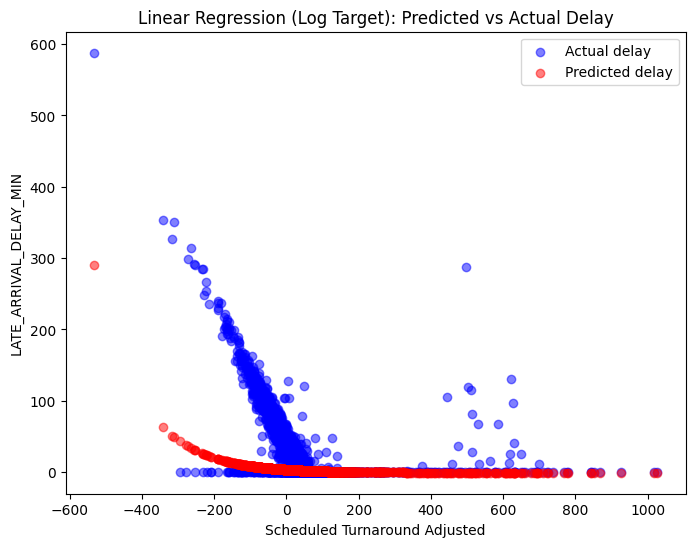

In [ ]:
#same linear regression with log transform due to curvature
X = df_final[['scheduled_turnaround_adjusted']]
y = df_final['LATE_ARRIVAL_DELAY_MIN']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lr = LinearRegression()
lr.fit(X_train, np.log1p(y_train))

y_pred = np.expm1(lr.predict(X_test))

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Linear Regression (log-transformed target) metrics:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

plt.figure(figsize=(8,6))
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Actual delay')
plt.scatter(X_test, y_pred, color='red', alpha=0.5, label='Predicted delay')
plt.xlabel('Scheduled Turnaround Adjusted')
plt.ylabel('LATE_ARRIVAL_DELAY_MIN')
plt.title('Linear Regression (Log Target): Predicted vs Actual Delay')
plt.legend()
plt.show()

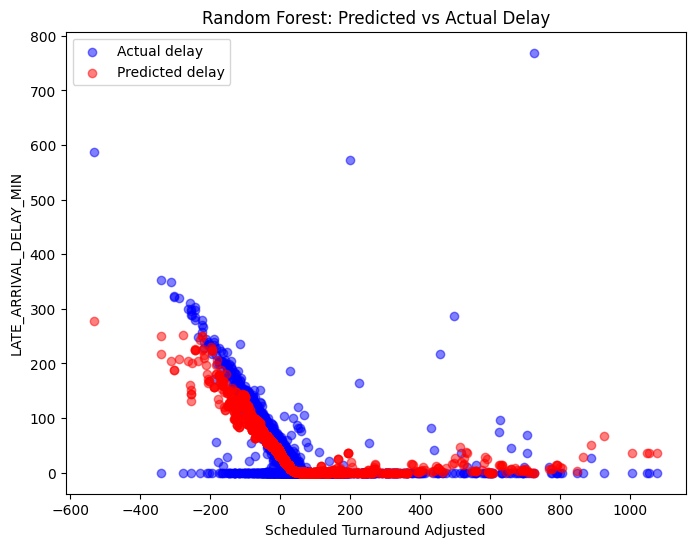

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

#Use other regressor 
#process data

X = df_final[['scheduled_turnaround_adjusted']]
y = df_final['LATE_ARRIVAL_DELAY_MIN']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predict on test
y_pred = rf.predict(X_test)


# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


with open("randomforestresults.txt", "w") as f:
    f.write("Random Forest Regressor metrics:\n")
    f.write(f"MAE: {mae:.4f}\n")
    f.write(f"RMSE: {rmse:.4f}\n")
    f.write(f"R²: {r2:.4f}\n")

plt.figure(figsize=(8,6))
plt.scatter(X_test, y_test, alpha=0.5, label='Actual delay')
plt.scatter(X_test, y_pred, alpha=0.5, label='Predicted delay')
plt.xlabel('Scheduled Turnaround Adjusted')
plt.ylabel('LATE_ARRIVAL_DELAY_MIN')
plt.title('Random Forest: Predicted vs Actual Delay')
plt.legend()

plt.savefig("randomforestresults.png", dpi=300, bbox_inches='tight')
plt.close()

#Plot
plt.figure(figsize=(8,6))
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Actual delay')
plt.scatter(X_test, y_pred, color='red', alpha=0.5, label='Predicted delay')
plt.xlabel('Scheduled Turnaround Adjusted')
plt.ylabel('LATE_ARRIVAL_DELAY_MIN')
plt.title('Random Forest: Predicted vs Actual Delay')
plt.legend()
plt.show()

## ADJUSTED TIME DECISION TREE (USING FULL DELAY INFO) (NOT USED)

In [27]:
df_model = df_final.copy()
df_model["MONTH"] = df_model["ARR_SCHEDULED"].dt.month
df_model["ARRIVAL_HOUR"] = df_model["ARR_ACTUAL"].dt.hour

features = ["CARRIER", "AIRPORT", "scheduled_turnaround_adjusted", "ARRIVAL_HOUR", "MONTH"]
target = "LATE_ARRIVAL_FLAG"

X_train, X_test, y_train, y_test = train_test_split(
    df_model[features], df_model[target], test_size=0.2, random_state=42, stratify=df_model[target]
)

categorical_features = ["CARRIER", "AIRPORT", "ARRIVAL_HOUR", "MONTH"]
numerical_features = ["scheduled_turnaround_adjusted"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

models = {
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", max_depth=20, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight="balanced", n_estimators=100, min_samples_leaf=5, max_depth=20, random_state=42)
}

for name, clf in models.items():
    pipeline = ImbPipeline(steps=[
        ("preprocess", preprocessor),
        ("resample", RandomUnderSampler(random_state=42)),
        ("clf", clf)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"{name} Confusion Matrix:\n{cm}\n")
    
    print(f"{name} Classification Report:\n{classification_report(y_test, y_pred)}\n")
    
    # Feature importances
    clf_model = pipeline.named_steps["clf"]
    # Get feature names after one-hot encoding
    cat_features = pipeline.named_steps["preprocess"].named_transformers_["cat"].get_feature_names_out(categorical_features)
    all_features = list(cat_features) + numerical_features
    importances = clf_model.feature_importances_
    
    print(f"{name} Feature Importances:")
    for f, imp in zip(all_features, importances):
        print(f"{f}: {imp:.4f}")
    print("\n")

Decision Tree Accuracy: 0.7971
Decision Tree Confusion Matrix:
[[3565  917]
 [ 404 1624]]

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.84      4482
           1       0.64      0.80      0.71      2028

    accuracy                           0.80      6510
   macro avg       0.77      0.80      0.78      6510
weighted avg       0.82      0.80      0.80      6510


Decision Tree Feature Importances:
CARRIER_AA: 0.0061
CARRIER_AS: 0.0017
CARRIER_B6: 0.0029
CARRIER_DL: 0.0070
CARRIER_F9: 0.0045
CARRIER_NK: 0.0074
CARRIER_OO: 0.0600
CARRIER_UA: 0.0049
CARRIER_WN: 0.0147
AIRPORT_DEN: 0.0120
AIRPORT_LGA: 0.0126
AIRPORT_MCI: 0.0087
AIRPORT_ORD: 0.0084
ARRIVAL_HOUR_0: 0.0000
ARRIVAL_HOUR_1: 0.0002
ARRIVAL_HOUR_2: 0.0001
ARRIVAL_HOUR_3: 0.0000
ARRIVAL_HOUR_4: 0.0001
ARRIVAL_HOUR_5: 0.0003
ARRIVAL_HOUR_6: 0.0002
ARRIVAL_HOUR_7: 0.0030
ARRIVAL_HOUR_8: 0.0059
ARRIVAL_HOUR_9: 0.0063
ARRIVAL_HOUR_10: 0.0072
ARRI